In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
plt.style.use([
    'notebook',
    'grid',
    {'figure.dpi': 150}
])

In [4]:
# dados simulacao

r = 31
mu = 40
sigma = 55
a4 = 3019

In [5]:
def non_linear_space_state(_, s, u, a_1, a_2, a_3, b_1, b_2, b_3):
   h3, h4 = s

   # colocar integral aqui dentro

   if h3 < 0:
      h3 = 0

   z1 = np.sqrt(h3)
   z2 = np.cos(2.5*np.pi * (h4 - mu)) / (sigma * np.sqrt(2 * np.pi))
   z3 = np.exp(-((h4 - mu)**2) / (2 * sigma**2))

   a3 = ((3*r)/5) * (2.7*r - (z2 * z3))

   beta = (b_3 - b_1) / (a3 * h3)
   zeta = (b_2 - b_3) / (a4 * h4)

   A = np.array([
      [-(a_3/a3) -((a_1*z1)/(a3*h3)) + beta, (a_3/a3)],
      [(a_3/a4), -(a_3/a4) + zeta]
   ])

   B = np.array([
      [0],
      [a_2/a4]
   ])

   h = np.array([
      [h3],
      [h4]
   ])

   return (A@h + B*u).flatten()

In [6]:
def simulate(s_0, coefficients, sim_time, sim_step, control_signal):
    time = np.arange(sim_time[0], sim_time[1], sim_step)
    time_span = [time[0], time[-1]]

    args = [control_signal]
    args = args + [coefficients[i] for i in range(len(coefficients))]

    s = solve_ivp(
        non_linear_space_state,
        y0=s_0,
        args=args,
        t_span=time_span,
        t_eval=time,
    )

    return s

In [7]:
c = np.array([
    1.04*(16.46),
    0.95*(32.4),
    0.93*(185.48),
    1.04*(-156.93),
    0.95*(-83.93),
    0.93*(-167.01)])

sol = simulate(
    [1e-3, 1e-3],
    c,
    [0, 2500],
    1,
    42
)

In [8]:
sim_steps = np.array([
    1,
    1,
    1,
    1,
    1
])

sim_control_signals = np.array([42, 37, 28, 55, 47])

def multiple_inputs_simulation(coefficients):
    s_0 = [1e-3, 1e-3]
    sim_time = [0, 2500]

    solutions = []

    last_s = s_0
    last_t = sim_time

    for i in range(len(sim_steps)):
        s = simulate(
            last_s,
            coefficients,
            last_t,
            sim_steps[i], 
            sim_control_signals[i]
        )

        last_s = s.y[:,-1]
        last_t = [last_t[-1], last_t[-1] + 2500]

        solutions.append(s)


    return solutions

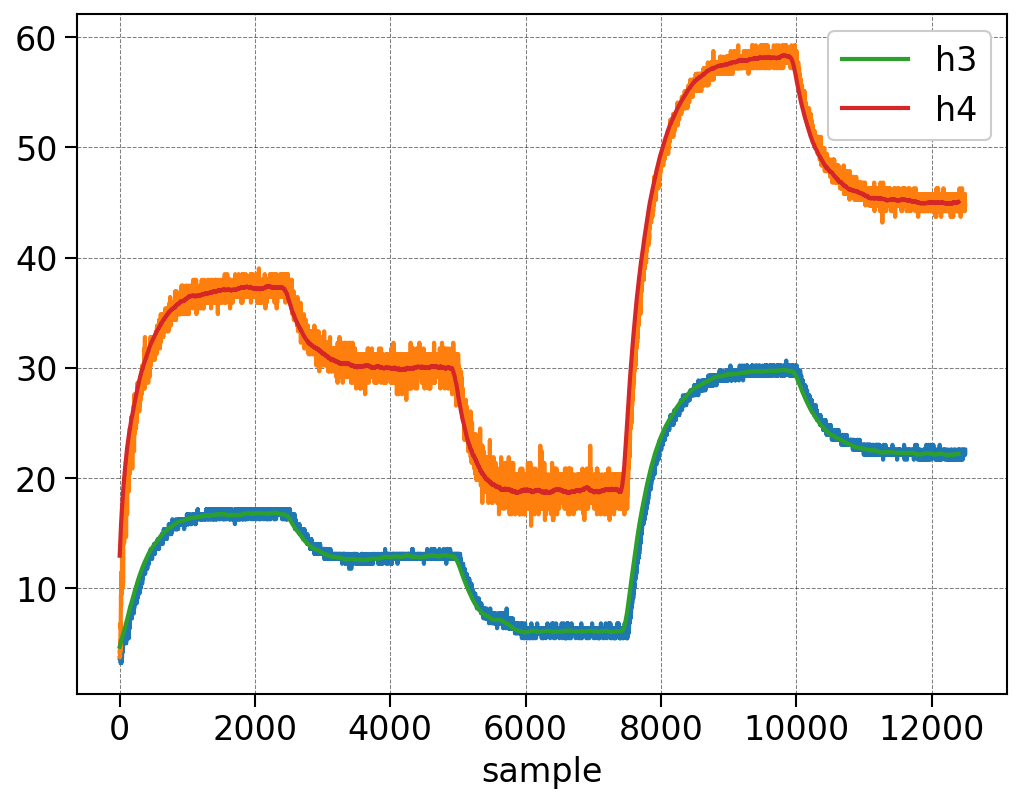

In [15]:
real_time = np.load('./data/t.npy')
level3 = np.load('./data/level3.npy')
level4 = np.load('./data/level4.npy')

# removing the noise using moving average
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


filtered_level3 = moving_average(level3, n=100)
filtered_level4 = moving_average(level4, n=100)

plt.plot(level3)
plt.plot(level4)

plt.plot(filtered_level3, label='h3')
plt.plot(filtered_level4, label='h4')
plt.xlabel('sample')
plt.legend()
plt.savefig('./images/filtered.png')

In [10]:
sol = simulate(
    [1e-3, 1e-3],
    [165.48, 16.46, 29.4, -147.01, -156.93, -83.93],
    [0, 60],
    1,
    50
)

In [11]:
solutions = multiple_inputs_simulation(
    [165.48, 16.46, 29.4, -147.01, -156.93, -83.93]
)

y = np.hstack([s.y for s in solutions])
t = np.hstack([s.t for s in solutions])

h3 = y[0, :]
h4 = y[1, :]

In [12]:
t = t[:len(level3)]
h3 = h3[:len(level3)]
h4 = h4[:len(level3)]

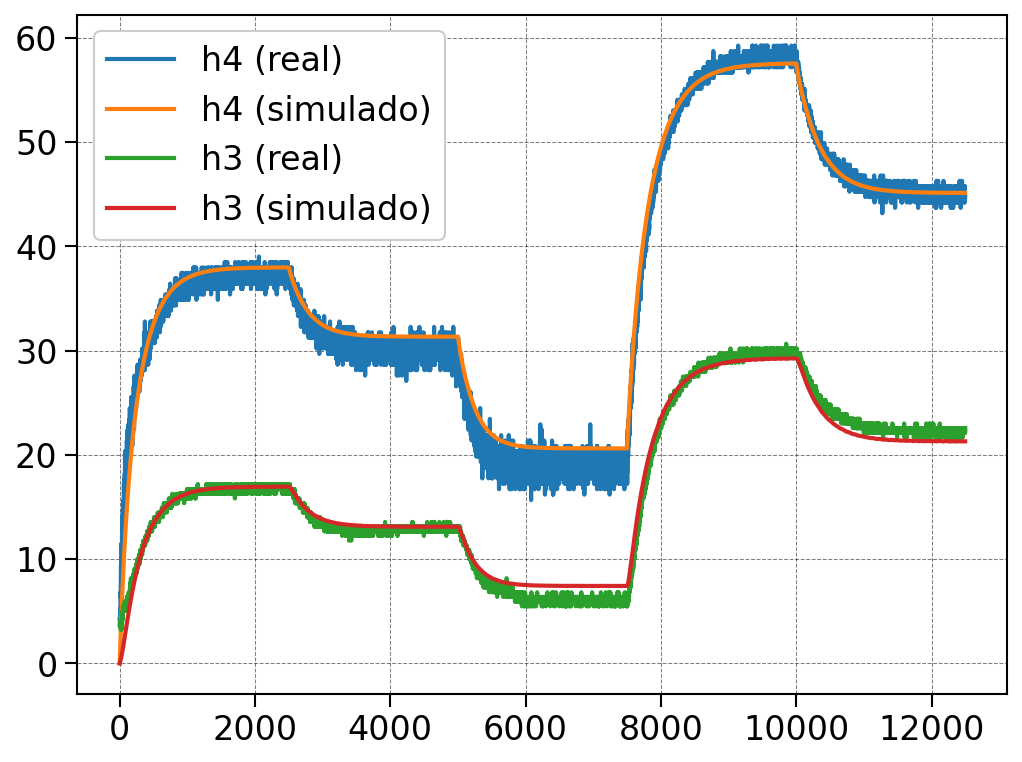

In [13]:
plt.plot(t, level4, label='h4 (real)')
plt.plot(t, h4, label='h4 (simulado)')

plt.plot(t, level3, label='h3 (real)')
plt.plot(t, h3, label='h3 (simulado)')

plt.legend()

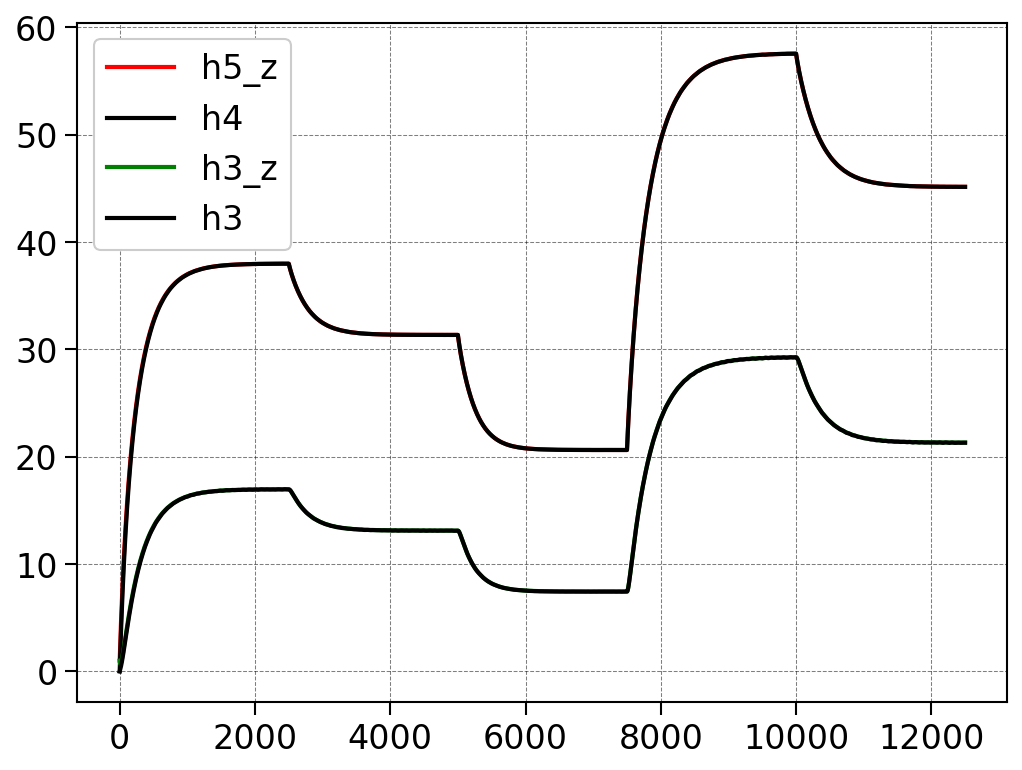

In [14]:
_h3 = np.load('./data/h3_z.npy')
_h4 = np.load('./data/h4_z.npy')

plt.plot(_h4, 'r-', label='h5_z')
plt.plot(h4, 'k', label='h4')

plt.plot(_h3, 'g-', label='h3_z')
plt.plot(h3, 'k', label='h3')
plt.legend()
plt.savefig('comp_integ.png', dpi=300)